**DATA Preparation**

In [300]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install pytreebank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37070 sha256=f555e5468fd3e4205633f2b47d5067708ad23f5c488b8a143683a767218d6999
  Stored in directory: /root/.cache/pip/wheels/01/52/f0/821edf3a28ad11d70e70ba858f46a0949c167c12133387a233
Successfully built pytreebank


In [ ]:
import pytreebank
# load the sentiment treebank corpus in the parenthesis format,
# e.g. "(4 (2 very ) (3 good))"
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["test"][2000]
# display it in the page
example.display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pytreebank
dataset = pytreebank.load_sst()
# example = dataset["test"][1]

# extract spans from the tree.
for label, sentence in example.to_labeled_lines():
	print("%s has sentiment label %s" % (
		sentence,
		["very negative", "negative", "neutral", "positive", "very positive"][label]
	))

Even by dumb action-movie standards , Ballistic : Ecks vs. Sever is a dumb action movie . has sentiment label very negative
Even by dumb action-movie standards has sentiment label very negative
Even has sentiment label neutral
by dumb action-movie standards has sentiment label negative
by has sentiment label neutral
dumb action-movie standards has sentiment label very negative
dumb has sentiment label negative
action-movie standards has sentiment label neutral
action-movie has sentiment label neutral
standards has sentiment label neutral
, Ballistic : Ecks vs. Sever is a dumb action movie . has sentiment label very negative
, has sentiment label neutral
Ballistic : Ecks vs. Sever is a dumb action movie . has sentiment label very negative
Ballistic : Ecks vs. Sever has sentiment label neutral
Ballistic : has sentiment label positive
Ballistic has sentiment label neutral
: has sentiment label neutral
Ecks vs. Sever has sentiment label neutral
Ecks vs. has sentiment label neutral
Ecks has

In [ ]:
example.to_lines()[0]

'Even by dumb action-movie standards , Ballistic : Ecks vs. Sever is a dumb action movie .'

In [ ]:
len(example.to_lines()[0].split())

17

In [ ]:
example.label

0

In [ ]:
sst_train = dataset["train"]
sst_val = dataset["dev"]
sst_test = dataset["test"]

In [ ]:
print(dataset["dev"][0].label)

3


In [ ]:
# for i in range(len(dataset["train"])):
#   print(dataset["train"][i].to_lines()[0])
#   print(dataset["train"][i].label)
#   print("_"*100)
#   if (i == 10):
#     break

**Neural Network Model**

**calculating fasttext feature vector using tf-idf**

FastText and TF-IDF are two distinct techniques and you can't directly calculate FastText embeddings using TF-IDF. However, you can use the TF-IDF weights as features to train a FastText model for text classification tasks. The idea is to first calculate the TF-IDF weights for each word in a document, and then use these weights as input features for the FastText model

In [ ]:
%pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4400070 sha256=78a291e4bddff499ffef20c670453308c5313c1eeaf55283022ad2926ed3825c
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
import fasttext
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
# Load the SST-5 dataset into a pandas dataframe
#df = pd.read_csv("sst-5.csv")
df = pd.DataFrame(columns=['text', 'label'])
for i in range(len(dataset["train"])):
#for i in range(10):
  df = df.append({'text': dataset["train"][i].to_lines()[0], 'label': dataset["train"][i].label}, ignore_index=True)


In [ ]:
df.head(25)

,text,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3
5,Whether or not you 're enlightened by any of D...,4
6,Just the labour involved in creating the layer...,4
7,Part of the charm of Satin Rouge is that it av...,3
8,a screenplay more ingeniously constructed than...,4
9,`` Extreme Ops '' exceeds expectations .,3


In [ ]:
len(df)

8544

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [ ]:
#reset indexing
X_train.reset_index(inplace = True,drop = True)
X_test.reset_index(inplace = True,drop = True)
y_train.reset_index(inplace = True,drop = True)
y_test.reset_index(inplace = True,drop = True)

In [ ]:
# Calculate the TF-IDF weights
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
print(X_train_tfidf[8])

  (0, 2969)	0.34220925017220416
  (0, 5518)	0.26546287475017
  (0, 1667)	0.14788704341503087
  (0, 10566)	0.2720196535717822
  (0, 11137)	0.2285621170062226
  (0, 11699)	0.3507501818011812
  (0, 2961)	0.29935687284868856
  (0, 4173)	0.2582020938331077
  (0, 12504)	0.34220925017220416
  (0, 2260)	0.3195084270460474
  (0, 6472)	0.12076807217413366
  (0, 11085)	0.20360123019708298
  (0, 4580)	0.1494852469718235
  (0, 563)	0.09212891122565127
  (0, 12272)	0.11115787719184443
  (0, 6069)	0.13050229557048018
  (0, 6461)	0.11431037942256128
  (0, 7036)	0.19102166549713662


In [ ]:
# Convert the TF-IDF matrix into a FastText-compatible format
#labels = [... ] # list of sentiment labels (positive, negative, neutral)
with open('movie_comments_tfidf_train.txt', 'w') as f:
    for i in range(X_train_tfidf.shape[0]):
        comment = X_train_tfidf[i, :].toarray().flatten().tolist()
        comment_str = ' '.join(str(x) for x in comment)
        #label = df['label'][i]
        label = y_train[i]
        f.write(f'__label__{label} {comment_str}\n')

In [ ]:
!mv movie_comments_tfidf_train.txt /content/drive/MyDrive/

In [ ]:
# Train the FastText model
model = fasttext.train_supervised(
    input='/content/drive/MyDrive/movie_comments_tfidf_train.txt',
    epoch=25,
    lr=0.01,
    wordNgrams=3,
    verbose=2,
    minCount=1
)


In [ ]:
# Save the FastText model to a file
model.save_model('fasttext_model_3.bin')

In [ ]:
!mv fasttext_model_3.bin /content/drive/MyDrive/

In [ ]:
# Load the FastText model from a file
model3 = fasttext.load_model('/content/drive/MyDrive/fasttext_model_3.bin')

In [ ]:
# Convert the TF-IDF matrix into a FastText-compatible format
with open('movie_comments_tfidf_test.txt', 'w') as f:
    for i in range(X_test_tfidf.shape[0]):
        comment = X_test_tfidf[i, :].toarray().flatten().tolist()
        comment_str = ' '.join(str(x) for x in comment)
        label = y_test[i]
        f.write(f'__label__{label} {comment_str}\n')

In [ ]:
!mv movie_comments_tfidf_test.txt /content/drive/MyDrive/

In [ ]:
# Evaluate the model on the test set
result = model3.test('/content/drive/MyDrive/movie_comments_tfidf_test.txt')
print("Accuracy: {:.4f}".format(result[1]))

Accuracy: 0.2855


In [ ]:
# Test the FastText model
result = model3.test('/content/drive/MyDrive/movie_comments_tfidf_test.txt')
# Print the results
print("Number of samples:", result[0])
print("Number of correctly classified samples:", result[1])
print("Accuracy:", result[2])

Number of samples: 1709
Number of correctly classified samples: 0.28554710356933877
Accuracy: 0.28554710356933877


In [ ]:
# Extract the FastText embeddings for each movie comment
# comments = [...] # list of movie comments
import numpy as np
comments_vectors = []
for comment in X_train:
    comment_vector = model3.get_sentence_vector(comment)
    comments_vectors.append(comment_vector)
comments_vectors = np.array(comments_vectors)

In [ ]:
comments_vectors[0] , len(comments_vectors)


(array([-2.58309970e-04, -1.41472861e-04,  2.23080075e-04, -3.68591194e-04,
         5.17100620e-04,  2.63320180e-05, -4.28772473e-04,  5.06409233e-05,
         7.75274239e-05,  3.44230975e-05,  1.37506708e-04, -2.38460343e-04,
        -3.89963272e-04, -1.26077299e-04, -5.51842269e-04, -9.08395014e-05,
        -2.75697766e-06,  2.40830646e-04, -2.03652118e-04,  7.77767054e-05,
        -3.47020046e-04,  6.47054636e-04,  1.99356109e-05, -6.47765919e-05,
        -2.71793106e-04,  5.24559910e-05, -2.89383897e-04, -1.04462291e-04,
         8.26012456e-06, -4.24766069e-04, -4.15245391e-04, -2.28162186e-04,
         2.53383914e-04, -3.65234223e-06, -5.06372831e-04,  7.05890761e-06,
        -5.44565963e-04,  2.58268610e-05, -2.70632212e-04,  2.04822809e-05,
        -1.40624819e-04,  1.21302764e-05,  1.13691101e-04, -2.03015181e-04,
         3.52081668e-04,  1.16307245e-04,  1.74693705e-04,  8.70655549e-06,
         5.09428464e-05, -1.51469401e-04, -2.88465992e-04,  5.48163189e-05,
         3.2

In [ ]:
# import tensorflow as tf
# # Define the Neural Network
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(comments_vectors.shape[1],)))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# #model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(5, activation='softmax'))


In [ ]:
# Define the model architecture
import tensorflow as tf
number_of_classes = 5
model_NN = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(comments_vectors.shape[1],), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])

In [ ]:
print(tf. __version__)

2.11.0


In [ ]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# def accuracy(y_true, y_pred):
#     return accuracy_score(y_true, y_pred)

# def recall(y_true, y_pred):
#     return recall_score(y_true, y_pred, average='macro')

# def precision(y_true, y_pred):
#     return precision_score(y_true, y_pred, average='macro')

# def f1(y_true, y_pred):
#     return f1_score(y_true, y_pred, average='macro')


In [ ]:
# def f1_score(y_true, y_pred):
#     precision = tf.keras.metrics.Precision()
#     recall = tf.keras.metrics.Recall()

#     precision.update_state(y_true, y_pred)
#     recall.update_state(y_true, y_pred)

#     f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result() + 1e-6)
#     return f1_score

In [ ]:
# Compile the Neural Network
opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
#loss=tf.keras.losses.sparse_categorical_crossentropy,
# def f1_score(y_true, y_pred):
#     true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
#     possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

#     precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
#     recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
#     f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

#     return f1_score

from keras import losses, metrics
#model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[accuracy, recall, precision, f1])
model_NN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.CategoricalAccuracy(),
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.AUC()])


In [ ]:
# Train the Neural Network
labels = y_train # list of sentiment labels (positive, negative, neutral , ...)
labels = np.array(labels)

In [ ]:
type(labels[0]) , labels[0] , len(labels)

(int, 3, 6835)

In [ ]:
labels = labels.astype(np.float32)

In [ ]:
labels[5:15]

array([1., 2., 0., 1., 3., 1., 4., 4., 1., 3.], dtype=float32)

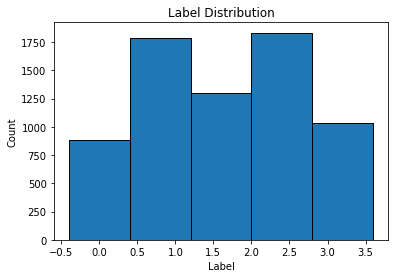

In [ ]:
import matplotlib.pyplot as plt
plt.hist(labels, bins=5, edgecolor='black', align='left')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [ ]:
#one-hot encoding of the labels
from keras.utils import to_categorical
num_classes = 5
onehot__labels = to_categorical(labels, num_classes)

In [ ]:
type(onehot__labels) , onehot__labels[0:5] , len(onehot__labels)

(numpy.ndarray, array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32), 6835)

In [ ]:
#labels = tf.convert_to_tensor(labels)
history = model_NN.fit(comments_vectors, onehot__labels, epochs=10, batch_size=20)

Epoch 1/10
342/342 [==============================] - 3s 3ms/step - loss: 0.5055 - categorical_accuracy: 0.2600 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - auc_22: 0.5906
Epoch 2/10
342/342 [==============================] - 1s 3ms/step - loss: 0.4910 - categorical_accuracy: 0.2759 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - auc_22: 0.5971
Epoch 3/10
342/342 [==============================] - 1s 3ms/step - loss: 0.4911 - categorical_accuracy: 0.2639 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - auc_22: 0.5943
Epoch 4/10
342/342 [==============================] - 1s 4ms/step - loss: 0.4913 - categorical_accuracy: 0.2658 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - auc_22: 0.5940
Epoch 5/10
342/342 [==============================] - 2s 5ms/step - loss: 0.4913 - categorical_accuracy: 0.2612 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - auc_22: 0.5926
Epoch 6/10
342/342 [==============================] - 2s 4ms/step - loss: 0.4909 - categorical_accur

In [ ]:
# Extract the FastText embeddings for each movie comment
# comments = [...] # list of movie comments
import numpy as np
comments_vectors_test = []
for comment in X_test:
    comment_vector = model3.get_sentence_vector(comment)
    comments_vectors_test.append(comment_vector)
comments_vectors_test = np.array(comments_vectors_test)

In [ ]:
X_test[0]

'Passion , melodrama , sorrow , laugther , and tears cascade over the screen effortlessly ...'

In [ ]:
labels_test = y_test # list of sentiment labels (positive, negative, neutral , ...)
labels_test = np.array(labels_test)

In [ ]:
labels_test = labels_test.astype(np.float32)

In [ ]:
num_classes = 5

onehot__test_labels = to_categorical(labels_test, num_classes)

In [ ]:
# evaluate the model on your test data
test_loss, test_accuracy, test_precision, test_recall , test_auc= model_NN.evaluate(comments_vectors_test, onehot__test_labels, verbose=0)


In [ ]:
# print the evaluation metrics
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
#print('Test F1 Score:', test_f1_score)

Test Loss: 0.4891107678413391
Test Accuracy: 0.2855471074581146
Test Precision: 0.0
Test Recall: 0.0


In [ ]:
#save the model and transfer it to google drive

In [ ]:
from sklearn.metrics import f1_score
predictions = model_NN.predict(comments_vectors_test)
# Convert the predictions to a class label
predicted_classes = np.argmax(predictions, axis=1)


54/54 [==============================] - 0s 3ms/step


In [ ]:
comments_vectors_test[15]

array([ 7.3021080e-04,  1.4696656e-04,  5.6710403e-04, -1.4912803e-06,
        5.8961275e-04,  4.0709542e-04, -7.3198264e-04, -1.9265947e-04,
        1.4458509e-04,  3.7303229e-04, -3.5889357e-04, -7.7376969e-04,
        1.6330899e-04, -2.0261963e-04, -7.0996711e-04,  6.2799460e-05,
        6.1145506e-04,  9.4383577e-05, -5.3546939e-04,  1.0449448e-04,
       -7.6653011e-04,  2.9669231e-04,  4.9684959e-04,  8.3598250e-04,
       -6.1351410e-04, -6.0705800e-04, -1.1518977e-03, -4.2659958e-04,
       -5.2528555e-04, -2.5437205e-04, -3.2602937e-04, -4.8271721e-04,
       -9.8497083e-05, -3.8539004e-04, -7.5040839e-04, -5.9474878e-05,
        1.2125875e-04, -1.5853398e-04,  1.7518505e-05, -2.5229386e-04,
       -4.9896096e-04,  7.5082370e-04, -6.3048449e-04, -2.4667601e-04,
        6.7000289e-04,  1.9496947e-06,  6.8647077e-04, -4.8048023e-04,
       -4.3587491e-04, -2.7962506e-04,  2.9483141e-04, -1.6951555e-05,
        5.0541223e-04, -1.2145081e-04, -8.4727339e-04,  2.9564041e-04,
      

In [ ]:
model_NN.predict(comments_vectors_test[15].reshape(1, -1))

1/1 [==============================] - 0s 104ms/step


array([[0.13126376, 0.26910216, 0.17463855, 0.27633804, 0.14865752]],
      dtype=float32)

In [ ]:
import pickle
# Save the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [ ]:
# Load the model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

In [ ]:
save_model(model_NN, 'NN_Sentimentmodel.bin')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......auc
.........vars
............0
............1
............2
............3
......categorical_accuracy
.........vars
............0
............1
......mean
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                             

In [301]:
!mv NN_Sentimentmodel.bin /content/drive/MyDrive/

In [302]:
model5 = load_model('/content/drive/MyDrive/NN_Sentimentmodel.bin')

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-02-13 05:02:36           64
variables.h5                                   2023-02-13 05:02:36       847912
config.json                                    2023-02-13 05:02:36         3070
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......auc
.........vars
............0
............1
............2
............3
......categorical_accuracy
.........vars
............0
............1
......mean
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
...

In [ ]:
predicted_classes[145:289]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
# Calculate the F1-score
f1 = f1_score(onehot__test_labels, predicted_classes, average='micro')

In [ ]:
text1 = 'i really love this movie'
text2 = 'i have it it was horibble'
text3 = 'it was not a bad movie'

In [ ]:
def test_NN(input_text, NN_model, fasttextmodel):
  input_features = input_text
  input_text_vector = fasttextmodel.get_sentence_vector(input_features)
  input_text_vector_NN = input_text_vector.reshape(1, -1)
  prediction = NN_model.predict(input_text_vector_NN)
  predicted_label = np.argmax(prediction)

  return predicted_label , prediction

In [ ]:
# input_features = vectorizer.transform([text2])
# # input_text_vector = model3.get_sentence_vector(input_features)


In [303]:
test_NN(text1, model5, model3)


1/1 [==============================] - 0s 111ms/step


(3, array([[0.13189603, 0.26851913, 0.17520055, 0.27518824, 0.14919607]],
       dtype=float32))

**THE Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:

# Create the TF-IDF feature vectors for the training and test data
#tfidf_vectorizer = TfidfVectorizer()
train_features = X_train_tfidf.astype(np.float32)
test_features = X_test_tfidf.astype(np.float32)
train_labels = y_train.astype(np.float32)
test_labels = y_test.astype(np.float32)

In [ ]:
#astype(np.float32)

In [ ]:
# Train a logistic regression model on the training data
clf = LogisticRegression()
clf.fit(train_features, train_labels)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:

# Use the trained model to make predictions on the test data
predictions = clf.predict(test_features)


In [ ]:

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.4078408425980105


In [ ]:
from sklearn.model_selection import cross_val_score


In [ ]:
# Perform 5-fold cross-validation
model = clf
X = train_features
y = train_labels
scores = cross_val_score(model, X, y, cv=5)

In [ ]:
# Calculate mean score and standard deviation
mean_score = np.mean(scores)
std_dev = np.std(scores)


In [ ]:
print("Mean score:", mean_score)
print("Standard deviation:", std_dev)

Mean score: 0.3926847110460863
Standard deviation: 0.010339171759505347


In [ ]:
import numpy as np

def predict_label(input_text, vectorizer, classifier):
    input_features = vectorizer.transform([input_text])
    prediction = classifier.predict(input_features)
    prediction_probabilities = classifier.predict_proba(input_features)
    predicted_label = prediction[0]
    predicted_probabilities = prediction_probabilities[0]
    
    return predicted_label, predicted_probabilities

In [ ]:
text1 = 'i really love this movie'

In [ ]:
text2 = 'i have it it was horibble'

In [ ]:
predict_label(text2,vectorizer,clf)

(2.0, array([0.28131721, 0.26789712, 0.28625569, 0.14202753, 0.02250245]))

**Downloading with gdown from the google drive**

In [314]:
!pip install --upgrade --no-cache-dir gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [315]:
#uploading models and data with gdwon
!gdown 1-2nV4Za-2lbhxSyHRvrdDUPXq3Cne1Y-

Downloading...
From: https://drive.google.com/uc?id=1-2nV4Za-2lbhxSyHRvrdDUPXq3Cne1Y-
To: /content/NN_Sentimentmodel.bin
100% 851k/851k [00:00<00:00, 122MB/s]


In [316]:
!gdown 1ANIGzY5hLWLrVn3spk45QBBudb5LjJu-

Downloading...
From: https://drive.google.com/uc?id=1ANIGzY5hLWLrVn3spk45QBBudb5LjJu-
To: /content/fasttext_model_3.bin
100% 840M/840M [00:07<00:00, 110MB/s] 


In [317]:
!gdown 13ZXX0jvW9WN4ol3qE2vjlNdE7VKxMwk9

Downloading...
From: https://drive.google.com/uc?id=13ZXX0jvW9WN4ol3qE2vjlNdE7VKxMwk9
To: /content/movie_comments_tfidf_train.txt
100% 375M/375M [00:04<00:00, 76.1MB/s]


In [307]:
!gdown 1w_FZzhytWIkU23C9244tlvCGPsjkObzV

Downloading...
From: https://drive.google.com/uc?id=1w_FZzhytWIkU23C9244tlvCGPsjkObzV
To: /content/movie_comments_tfidf_test.txt
100% 93.9M/93.9M [00:01<00:00, 77.1MB/s]


In [318]:
!gdown 1-1yGMjrTuGJE3A47PyaJYfVpRJxpUZWX

Downloading...
From: https://drive.google.com/uc?id=1-1yGMjrTuGJE3A47PyaJYfVpRJxpUZWX
To: /content/fasttext_model.bin
100% 840M/840M [00:10<00:00, 82.8MB/s]
